In [1]:
import pyNUISANCE as pn
import pyProSelecta as pps
import pyNuHepMC as nhm

In [2]:
evs = pn.EventSource("neutvect.t2kflux_numu_C_nofsi.root")
if not evs:
    print("Error: failed to open input file")

In [3]:
# the above line stops NEUT printouts
wf = pn.WeightCalcFactory()
t2krw = wf.make(evs, {"plugin_name":"T2KReWeight", "neut_cardname": "neut.t2kflux_numu_C_nofsi.card"})

ll: 0, limit = 3
 did scope guard 
 CRSPATH_ENV: /opt/neut/git_master/share/neut/crsdat
 Reading neut.t2kflux_numu_C_nofsi.card as card
 ======= CONFIGURATION FOR INTERACTIONS =======
 Reading neut.t2kflux_numu_C_nofsi.card as a card file
 Using Spectral Function for elastic events
 NECARD : INPUTTED PARAMETER 
 NECARD : CRSPATH= /opt/neut/git_master/share/neut/crsdat/
 NECARD : FERM   =            0
 NECARD : PAUL   =            1
 NECARD : PAUL2p2h =            0
 NECARD : NEFF   =            1
 NECARD : NUCDEXITE =            0
 NECARD : MODL   =            1
 NECARD : MODH   =            1
 NECARD : KINH   =            1
 NECARD : MODE   =            0
 NECARD : COHEPI =            2
 NECARD : DIFPI  =            0
 ********* CCQE SETTINGS ***************
 NECARD : MDLQE   =          402
 NECARD : MDLQEAF =            1
 NECARD : MDL2P2H =            2
 NECARD : NV2P2HQVAL =            1
 NECARD : MAQE    =    1.21000004    
 NECARD : AXFFALPHA =  0.230000004    
 NECARD : AXFFBETA

In [4]:
pps.load_text("""
std::vector<double> kinvars(HepMC3::GenEvent const &ev){
  std::vector<double> rtn(6,0xdeadbeef);

  auto const &[nu,mu] = ps::sel::PrimaryLeptonsForNuCC(ev,14);
  if(!nu) {
      return rtn;
  }

  rtn[0] = nu->momentum().e() *1E-3;
  rtn[1] = ps::proj::parts::q0(nu,mu)*1E-3;
  rtn[2] = ps::proj::parts::q3(nu,mu)*1E-3;
  rtn[3] = ps::proj::parts::Q2(nu,mu)*1E-6;

  rtn[4] = mu->momentum().p3mod()*1E-3;
  rtn[5] = std::cos(mu->momentum().theta());

  return rtn;
}
""")

True

In [5]:
import pprint

all_dials = []
for tgt in [ "C", ]:
    for nus in [ "nu", ]:
        for bi in range(3):
            all_dials.append("HFPW_toCRPAPWTwkDial_%s_%s_%s" % (tgt,nus,bi))
            all_dials.append("HFPW_toHFTwkDial_%s_%s_%s" % (tgt,nus,bi))

dial_tweaks = {}
for var in [1]:
    for di in all_dials:
        twk = {}
        for dj in all_dials:
            twk[dj] = var if di == dj else 0
        dial_tweaks["%s=%s" % (di,var)] = twk

dial_tweaks["CV"] = {"HFPW_toCRPAPWTwkDial_C_nu_0":0,
                     "HFPW_toCRPAPWTwkDial_C_nu_1":0,
                     "HFPW_toCRPAPWTwkDial_C_nu_2":0,
                     "HFPW_toHFTwkDial_C_nu_0":0,
                     "HFPW_toHFTwkDial_C_nu_1":0,
                     "HFPW_toHFTwkDial_C_nu_2":0}
# pprint.pp(dial_tweaks)
colnames = [ x for x in dial_tweaks.keys() ]
pprint.pp(colnames)

['HFPW_toCRPAPWTwkDial_C_nu_0=1',
 'HFPW_toHFTwkDial_C_nu_0=1',
 'HFPW_toCRPAPWTwkDial_C_nu_1=1',
 'HFPW_toHFTwkDial_C_nu_1=1',
 'HFPW_toCRPAPWTwkDial_C_nu_2=1',
 'HFPW_toHFTwkDial_C_nu_2=1',
 'CV']


In [6]:
def wghts(ev):
    resp = []
    for _,var in dial_tweaks.items():
        t2krw.set_parameters(var)
        resp.append(t2krw.calc_weight(ev))
    return resp

In [7]:
fg = pn.EventFrameGen(evs, 250000)\
  .filter(pps.select.process_id_exact(200)) \
  .add_columns(["enu","q0","q3","Q2lep","plep","cthetalep"], pps.project.get_vect("kinvars")) \
  .add_columns(colnames, wghts)
print(fg.first(20))

 ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 | event.number | weight.cv | process.id |    enu |      q0 |      q3 |   Q2lep |   plep | cthetalep | HFPW_toCRPA$ | HFPW_toHFTw$ | HFPW_toCRPA$ | HFPW_toHFTw$ | HFPW_toCRPA$ | HFPW_toHFTw$ | CV |
 ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 |            3 |         1 |        200 | 0.3478 | 0.07578 |  0.2856 | 0.07581 | 0.2507 |    0.5864 |       0.8316 |       0.7581 |            1 |            1 |            1 |            1 |  1 |
 |            4 |         1 |        200 | 0.6416 |  0.1607 |  0.6537 |  0.4015 | 0.4692 |    0.3396 |            1 |            1 |       0.9885 |        1.025 |            1 |            1 |  1 |
 |        

In [8]:
chunk = fg.firstArrow(int(1E6))

NCCQE = 407323, NTotal = 1000000


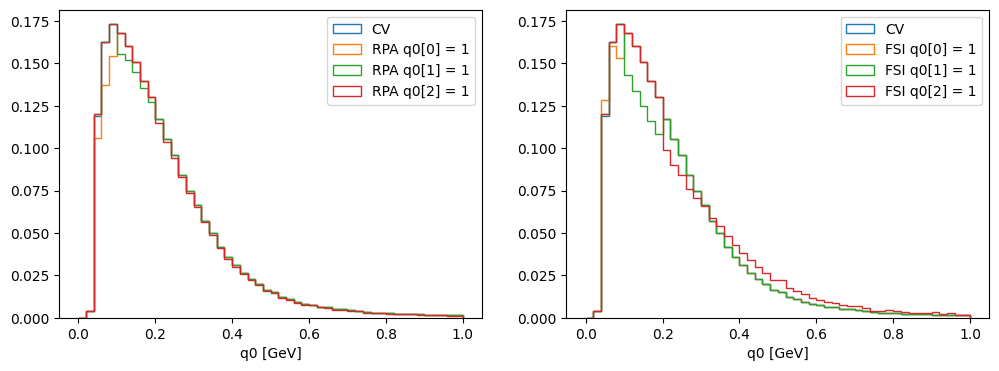

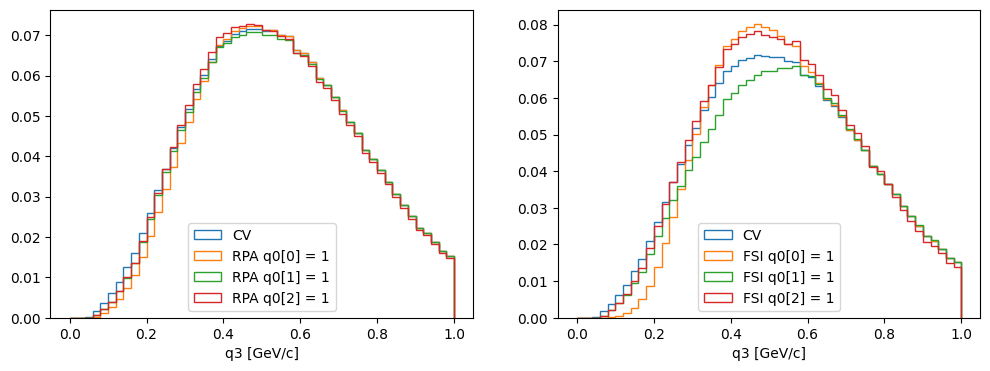

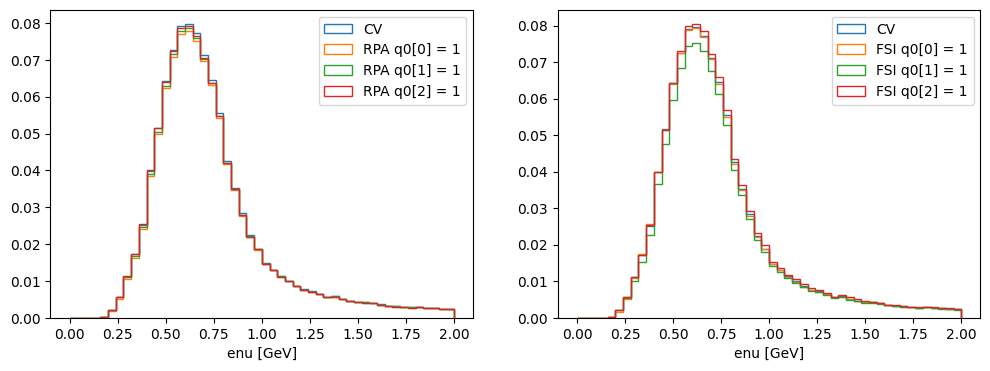

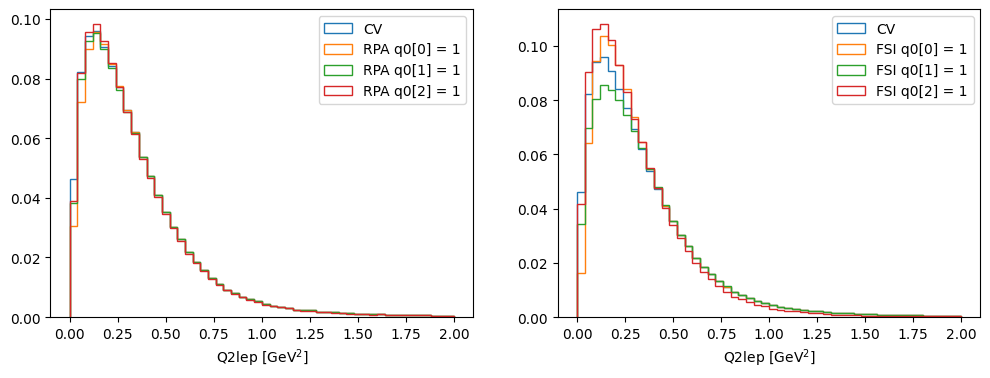

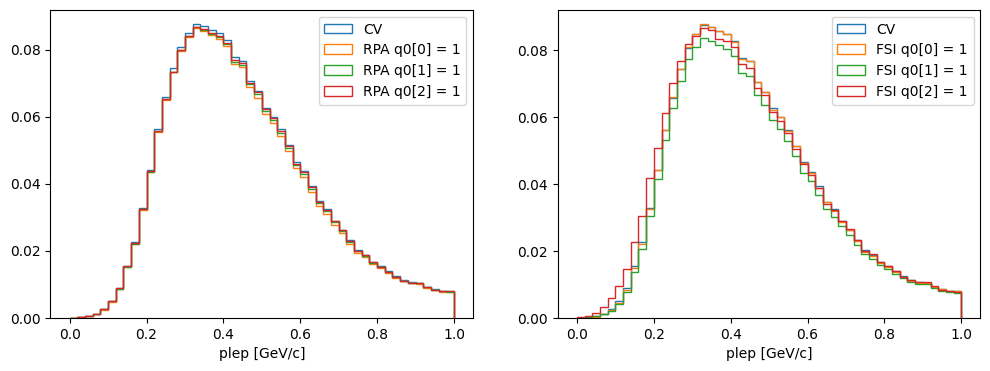

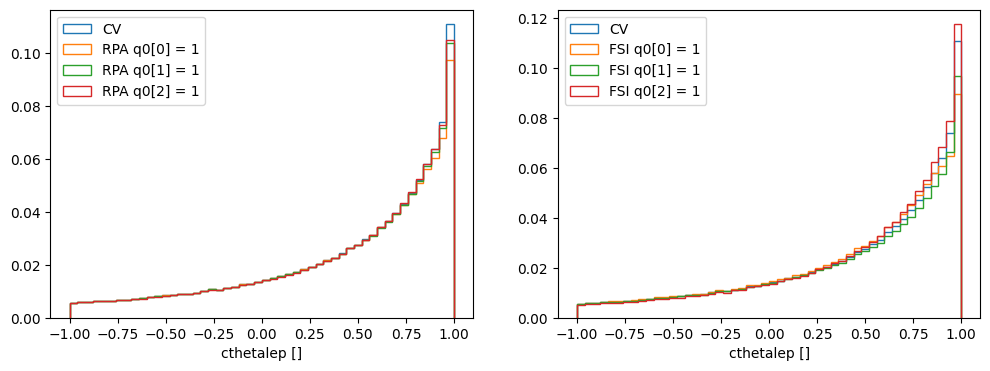

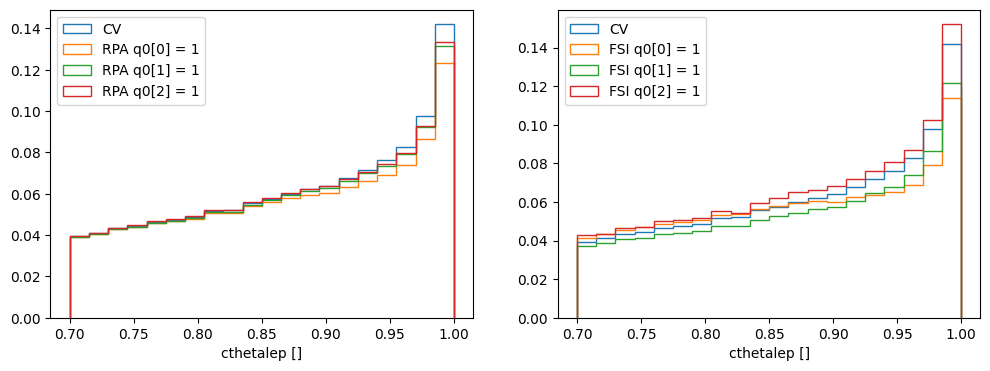

In [9]:
import numpy as np
import matplotlib.pyplot as plt

print("NCCQE = %s, NTotal = %s" %(chunk.num_rows, fg.norm_info().nevents))

plots = [
    ("q0","GeV", (0,1,50)),
    ("q3","GeV/c", (0,1,50)),
    ("enu","GeV", (0,2,50)),
    ("Q2lep",r"$\text{GeV}^{2}$", (0,2,50)),
    ("plep","GeV/c", (0,1,50)),
    ("cthetalep","", (-1,1,50)),
    ("cthetalep","", (0.7,1,20)),
]
for prj,unit,bins in plots:
    kin_hist = pn.HistFrame(pn.Binning.lin_space(*bins))
    kin_hist.fill_weighted_columns_from_Arrow(chunk,[prj],
                                              [ "HFPW_toCRPAPWTwkDial_C_nu_0=1",
                                                "HFPW_toCRPAPWTwkDial_C_nu_1=1",
                                                "HFPW_toCRPAPWTwkDial_C_nu_2=1",
                                                "HFPW_toHFTwkDial_C_nu_0=1",
                                                "HFPW_toHFTwkDial_C_nu_1=1",
                                                "HFPW_toHFTwkDial_C_nu_2=1"], ["CV", "weight.cv"])
    # scale to diff xs in pb/A
    kin_hist.sumweights = (kin_hist.sumweights / kin_hist.binning.bin_sizes()[:,np.newaxis]) * fg.norm_info().fatx_per_sumweights()
    
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    
    kin_hist.mpl().hist_all(columns=["mc",
        "HFPW_toCRPAPWTwkDial_C_nu_0=1","HFPW_toCRPAPWTwkDial_C_nu_1=1","HFPW_toCRPAPWTwkDial_C_nu_2=1"],
        labels=["CV", "RPA q0[0] = 1", "RPA q0[1] = 1", "RPA q0[2] = 1"],
        histtype='step', plot_axis=axes[0])
    
    axes[0].set_xlabel("%s [%s]" % (prj,unit))
    axes[0].legend()

    kin_hist.mpl().hist_all(columns=["mc",
        "HFPW_toHFTwkDial_C_nu_0=1","HFPW_toHFTwkDial_C_nu_1=1","HFPW_toHFTwkDial_C_nu_2=1"],
        labels=["CV", "FSI q0[0] = 1", "FSI q0[1] = 1", "FSI q0[2] = 1"],
        histtype='step', plot_axis=axes[1])
    
    axes[1].set_xlabel("%s [%s]" % (prj,unit))
    axes[1].legend()
    
    fig.show()

/tmp/ipykernel_8122/4243841778.py:15: RuntimeWarning: invalid value encountered in divide
  stupid_eigennumpy[:,0] = np.divide(q0q3h.sumweights[:,1],q0q3h.sumweights[:,0])


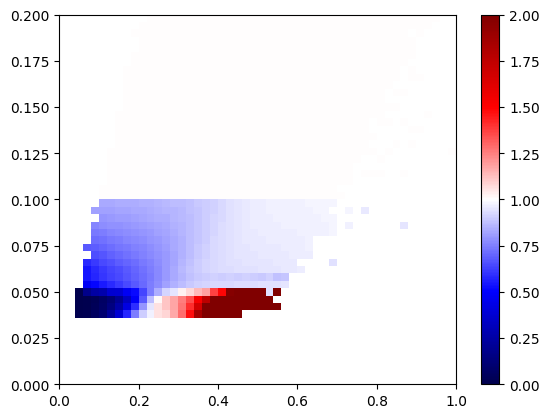

In [12]:
from copy import copy
import matplotlib as mpl

q0q3h = pn.HistFrame(pn.Binning.lin_spaceND([[0,1,50],[0,0.2,50]]))
q0q3h.fill_weighted_columns_from_Arrow(chunk,["q3","q0"],
                                          [ "HFPW_toCRPAPWTwkDial_C_nu_0=1",
                                            "HFPW_toCRPAPWTwkDial_C_nu_1=1",
                                            "HFPW_toCRPAPWTwkDial_C_nu_2=1",
                                            "HFPW_toHFTwkDial_C_nu_0=1",
                                            "HFPW_toHFTwkDial_C_nu_1=1",
                                            "HFPW_toHFTwkDial_C_nu_2=1"], ["CV", "weight.cv"])

q0q3h_rpa0 = copy(q0q3h)
stupid_eigennumpy = q0q3h_rpa0.sumweights.copy()
stupid_eigennumpy[:,0] = np.divide(q0q3h.sumweights[:,1],q0q3h.sumweights[:,0])
q0q3h_rpa0.sumweights = stupid_eigennumpy
q0q3h_rpa0.mpl().colormesh(plot_axis=plt,vmin=0,vmax=2, cmap=mpl.colormaps["seismic"])
plt.colorbar()
plt.show()

/tmp/ipykernel_8122/1084292048.py:12: RuntimeWarning: invalid value encountered in divide
  stupid_eigennumpy[:,0] = np.divide(q0q3h.sumweights[:,1],q0q3h.sumweights[:,0])


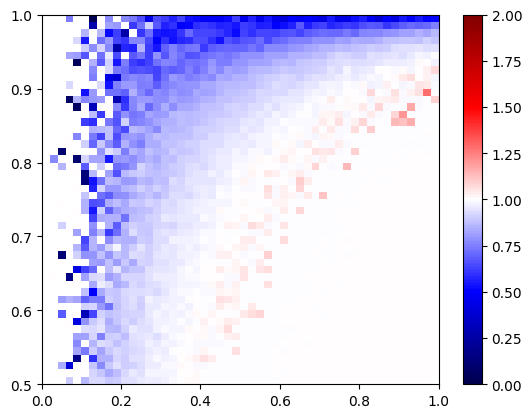

In [13]:
q0q3h = pn.HistFrame(pn.Binning.lin_spaceND([[0,1,50],[0.5,1,50]]))
q0q3h.fill_weighted_columns_from_Arrow(chunk,["plep","cthetalep"],
                                          [ "HFPW_toCRPAPWTwkDial_C_nu_0=1",
                                            "HFPW_toCRPAPWTwkDial_C_nu_1=1",
                                            "HFPW_toCRPAPWTwkDial_C_nu_2=1",
                                            "HFPW_toHFTwkDial_C_nu_0=1",
                                            "HFPW_toHFTwkDial_C_nu_1=1",
                                            "HFPW_toHFTwkDial_C_nu_2=1"], ["CV", "weight.cv"])

q0q3h_rpa0 = copy(q0q3h)
stupid_eigennumpy = q0q3h_rpa0.sumweights.copy()
stupid_eigennumpy[:,0] = np.divide(q0q3h.sumweights[:,1],q0q3h.sumweights[:,0])
q0q3h_rpa0.sumweights = stupid_eigennumpy
q0q3h_rpa0.mpl().colormesh(plot_axis=plt,vmin=0,vmax=2, cmap=mpl.colormaps["seismic"])
plt.colorbar()
plt.show()